In [1]:
%cd ..

/Users/juansegundohevia/Documents/repos/TexTract


In [3]:
import pix2tex.cli as cli
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd 
import pickle as pkl
from pix2tex.dataset.dataset import Im2LatexDataset
import yaml

In [20]:
from typing import Tuple
from pix2tex.dataset.dataset import Im2LatexDataset
import numpy as np
import torch
from torchtext.data import metrics
from munch import Munch
from tqdm.auto import tqdm
from Levenshtein import distance

from pix2tex.utils import *
from pix2tex.eval import detokenize
import re
from pix2tex.dataset.transforms import test_transform
import pandas.io.clipboard as clipboard
from PIL import ImageGrab
from PIL import Image
from pathlib import Path
from typing import List, Optional, Tuple
import re


from pix2tex.utils import *
from pix2tex.model.checkpoints.get_latest_checkpoint import download_checkpoints
from pix2tex.eval import detokenize

def minmax_size(img: Image, max_dimensions: Tuple[int, int] = None, min_dimensions: Tuple[int, int] = None) -> Image:
    """Resize or pad an image to fit into given dimensions

    Args:
        img (Image): Image to scale up/down.
        max_dimensions (Tuple[int, int], optional): Maximum dimensions. Defaults to None.
        min_dimensions (Tuple[int, int], optional): Minimum dimensions. Defaults to None.

    Returns:
        Image: Image with correct dimensionality
    """
    if max_dimensions is not None:
        ratios = [a/b for a, b in zip(img.size, max_dimensions)]
        if any([r > 1 for r in ratios]):
            size = np.array(img.size)//max(ratios)
            img = img.resize(size.astype(int), Image.BILINEAR)
    if min_dimensions is not None:
        # hypothesis: there is a dim in img smaller than min_dimensions, and return a proper dim >= min_dimensions
        padded_size = [max(img_dim, min_dim) for img_dim, min_dim in zip(img.size, min_dimensions)]
        if padded_size != list(img.size):  # assert hypothesis
            padded_im = Image.new('L', padded_size, 255)
            padded_im.paste(img, img.getbbox())
            img = padded_im
    return img



def extraer_numero(texto):
    """
    Función para extraer el primer número encontrado en una cadena de texto.

    Parámetros:
    - texto (str): La cadena de texto de la cual extraer el número.

    Retorna:
    - str: El primer número encontrado en la cadena de texto.
    - None: Si no se encuentra ningún número.
    """
    # Utilizar expresión regular para encontrar todos los números en la cadena
    numeros = re.findall(r'\d+', texto)

    # Asumiendo que solo hay un número en la cadena, obtener el primer resultado
    numero = numeros[0] if numeros else None

    return numero

def get_bleu_per_seq(model, dataset: Im2LatexDataset, args: Munch, resize=True, device="cpu"):
    """evaluates the model. Returns bleu score on the dataset

    Args:
        model (torch.nn.Module): the model
        dataset (Im2LatexDataset): test dataset
        args (Munch): arguments
        num_batches (int): How many batches to evaluate on. Defaults to None (all batches).
        name (str, optional): name of the test e.g. val or test for wandb. Defaults to 'test'.

    Returns:
        Tuple[float, float, float]: BLEU score of validation set, normed edit distance, token accuracy
    """
    assert len(dataset) > 0
    output = {}
    iter_ds = iter(dataset)
    pbar = tqdm(enumerate(iter_ds), total=len(dataset))

# 
    for i, (seq, im) in pbar:
        #image_index = dataset.indices[i]
        if seq is None or im is None:
            continue

        # Preprocess img
        # img = minmax_size(pad(im), args.max_dimensions, args.min_dimensions)
        # img = np.array(pad(img).convert('RGB'))
        # t = test_transform(image=img)['image'][:1].unsqueeze(0)
        # im = t.to(device)
        
        #genero prediccion
        dec = model.generate(im.to(device), temperature=args.get('temperature', .2))
        pred = detokenize(dec, dataset.tokenizer)
        truth = detokenize(seq['input_ids'], dataset.tokenizer)
        #calculo bleu score
        bleu = metrics.bleu_score(pred, [alternatives(x) for x in truth])
        #armo la expresion de vuelta
        pred2 = token2str(dec, dataset.tokenizer)
        truth2 = token2str(seq['input_ids'], dataset.tokenizer)
        #post process y edit_dist
        edit_dist = []
        for predi, truthi in zip(pred2, truth2):
            ts = post_process(truthi)
            if len(ts) > 0:
                edit_dist.append(distance(post_process(predi), ts)/len(ts))    
        dec = dec.cpu()
        tgt_seq = seq['input_ids'][:, 1:]
        shape_diff = dec.shape[1]-tgt_seq.shape[1]
        if shape_diff < 0:
            dec = torch.nn.functional.pad(dec, (0, -shape_diff), "constant", args.pad_token)
        elif shape_diff > 0:
            tgt_seq = torch.nn.functional.pad(tgt_seq, (0, shape_diff), "constant", args.pad_token)
        mask = torch.logical_or(tgt_seq != args.pad_token, dec != args.pad_token)
        tok_acc = (dec == tgt_seq)[mask].float().mean().item()       
        
        #Busco el nombre de la imagen 
        batch = iter_ds.pairs[iter_ds.i - 1]
        _,ims=batch.T
        label = extraer_numero(ims[0])
        output[label] = {
            "Truth":truth2,
            "predicted":pred2,
            "Bleu_score": bleu,
            "Edit dist": np.mean(edit_dist),
            "Tok acc" : tok_acc}
        
    
    return output

In [13]:
# load original model

with open("pix2tex/model/settings/config.yaml", "r") as f:
    config_original = yaml.load(f, Loader=yaml.FullLoader)

original = cli.LatexOCR()


In [22]:
# load handwritten dataset
dataset_test_hw = Im2LatexDataset(pad=True).load("pix2tex/dataset/handwritten/test.pkl")

In [23]:
out = get_bleu_per_seq(original.model, dataset_test_hw, config_original)

  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/1083 [00:00<?, ?it/s]


IndexError: index 526 is out of bounds for dimension 0 with size 505

# Replicate eval.py logic

In [28]:
import pix2tex.utils as p2t_utils
import pix2tex.models as p2t_models

CONFIG_PATH = "pix2tex/model/settings/config.yaml"
BATCHSIZE = 1
TEMPERATURE = .9
CHECKPOINT_PATH = "hw_checkpoints/handwritten_training/handwritten_training_e19_step63.pth"
DEVICE = "cpu"
DATA_PATH = "pix2tex/dataset/handwritten/test.pkl"

with open(CONFIG_PATH, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

args = p2t_utils.parse_args(Munch(config))

args.testbatchsize = BATCHSIZE
args.wandb = False
args.temperature = TEMPERATURE

model = p2t_models.get_model(args)
model.load_state_dict(torch.load(CHECKPOINT_PATH, DEVICE))

dataset = Im2LatexDataset(pad=True).load(DATA_PATH)
valargs = args.copy()
valargs.update(batchsize=args.testbatchsize, keep_smaller_batches=True, test=True)
dataset.update(**valargs)

In [45]:
from collections import defaultdict

def evaluate(model, dataset: Im2LatexDataset, args: Munch, num_batches: int = None, name: str = 'test'):
    """evaluates the model. Returns bleu score on the dataset

    Args:
        model (torch.nn.Module): the model
        dataset (Im2LatexDataset): test dataset
        args (Munch): arguments
        num_batches (int): How many batches to evaluate on. Defaults to None (all batches).
        name (str, optional): name of the test e.g. val or test for wandb. Defaults to 'test'.

    Returns:
        Tuple[float, float, float]: BLEU score of validation set, normed edit distance, token accuracy
    """
    assert len(dataset) > 0
    device = args.device
    bleus, edit_dists, token_acc = [], [], []
    bleu_score, edit_distance, token_accuracy = 0, 1, 0
    pbar = tqdm(enumerate(iter(dataset)), total=len(dataset))
    preds = defaultdict(list)
    for i, (seq, im) in pbar:
        if seq is None or im is None:
            continue
        #loss = decoder(tgt_seq, mask=tgt_mask, context=encoded)
        dec = model.generate(im.to(device), temperature=args.get('temperature', .2))
        pred = detokenize(dec, dataset.tokenizer)
        preds[i].append(pred)
        truth = detokenize(seq['input_ids'], dataset.tokenizer)
        bleus.append(metrics.bleu_score(pred, [alternatives(x) for x in truth]))
        for predi, truthi in zip(token2str(dec, dataset.tokenizer), token2str(seq['input_ids'], dataset.tokenizer)):
            ts = post_process(truthi)
            if len(ts) > 0:
                edit_dists.append(distance(post_process(predi), ts)/len(ts))
        dec = dec.cpu()
        tgt_seq = seq['input_ids'][:, 1:]
        shape_diff = dec.shape[1]-tgt_seq.shape[1]
        if shape_diff < 0:
            dec = torch.nn.functional.pad(dec, (0, -shape_diff), "constant", args.pad_token)
        elif shape_diff > 0:
            tgt_seq = torch.nn.functional.pad(tgt_seq, (0, shape_diff), "constant", args.pad_token)
        mask = torch.logical_or(tgt_seq != args.pad_token, dec != args.pad_token)
        tok_acc = (dec == tgt_seq)[mask].float().mean().item()
        token_acc.append(tok_acc)
        pbar.set_description('BLEU: %.3f, ED: %.2e, ACC: %.3f' % (np.mean(bleus), np.mean(edit_dists), np.mean(token_acc)))
        if num_batches is not None and i >= num_batches:
            break
    if len(bleus) > 0:
        bleu_score = np.mean(bleus)
    if len(edit_dists) > 0:
        edit_distance = np.mean(edit_dists)
    if len(token_acc) > 0:
        token_accuracy = np.mean(token_acc)

    print('\n%s\n%s' % (truth, pred))
    print('BLEU: %.2f' % bleu_score)
    return bleu_score, edit_distance, token_accuracy, bleus, edit_dists, token_acc, preds

In [46]:
bleu_score, edit_distance, token_accuracy, bleu_list, edit_dists_list, token_acc_list, preds = evaluate(model, dataset, args)

BLEU: 0.634, ED: 4.00e-01, ACC: 0.585: 100%|██████████| 729/729 [03:22<00:00,  3.60it/s]


[['z', '_', '{', 'n', '+', '1', '}', '=', 'p', '(', 'z', '_', '{', 'n', '}', ')', '=', '(', 'z', '_', '{', 'n', '}', ')', '^', '{', '2', '}']]
[['z', '_', '{', 'n', '+', '1', '}', '=', 'p', '(', 'z', '_', '{', 'n', '}', ')', '=', '(', 'z', '_', '{', 'n', '}', ')', '^', '{', '2', '}']]
BLEU: 0.63


In [48]:
bleu_list

[0.42303482598668557,
 1.0,
 0.9427781105041504,
 0.5923033356666565,
 1.0,
 0.6364716614387282,
 0.8895260095596313,
 1.0,
 0.809106707572937,
 1.0,
 0.41205424070358276,
 1.0,
 1.0,
 0.5521711111068726,
 0.9234732985496521,
 0.15138515830039978,
 1.0,
 0.47252970933914185,
 0.0,
 0.7300205552295784,
 0.6869622917999098,
 1.0,
 1.0,
 0.3368584215641022,
 0.0,
 0.7016116380691528,
 0.2467789500951767,
 0.658854603767395,
 0.4925399720668793,
 0.0,
 0.6017199754714966,
 0.7764520049095154,
 0.2666354289870997,
 1.0,
 1.0,
 0.5328009724617004,
 0.5035338401794434,
 0.0,
 1.0,
 0.773932158946991,
 1.0,
 0.916930079460144,
 0.0,
 1.0,
 1.0,
 1.0,
 0.8895260095596313,
 0.7930231094360352,
 0.7267243773920372,
 1.0,
 1.0,
 1.0,
 0.0,
 0.5231223946970852,
 0.2770519260065613,
 0.7627667783855808,
 0.8818476182028909,
 1.0,
 0.364562340366121,
 1.0,
 0.5706625083643903,
 0.0,
 0.0,
 1.0,
 0.6177712427736617,
 0.0,
 0.6407118077540715,
 0.41374412178993225,
 0.7809325934695621,
 0.6767781376838

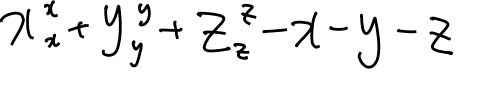

In [43]:
Image.open(dataset.pairs[0][0][1])

In [58]:
np.array(preds[0]).squeeze()

def parse_prediction(pred):
    pred = np.array(pred).squeeze()
    return ''.join(pred)

print(parse_prediction(preds[np.argmax(bleu_list)]))

\sqrt{1+\sqrt{1+\sqrt{1+\sqrt{x}}}}


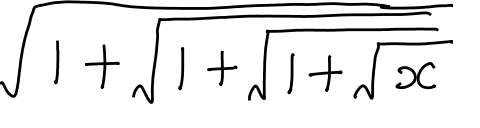

In [55]:
Image.open(dataset.pairs[np.argmax(bleu_list)][0][1])

$\sqrt{1+\sqrt{1+\sqrt{1+\sqrt{x}}}}$